## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm_notebook

## Config

In [2]:
cat_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - Basic
  - PastAssessment
  - PastGame

av:
  split_params:
    test_size: 0.33
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 1000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "catboost"
  mode: "regression"
  model_params:
    loss_function: "RMSE"
    task_type: "CPU"
    iterations: 6000
    early_stopping_rounds: 100
    random_seed: 42

  train_params:
    mode: "regression"
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''


lgb_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - Basic
  - PastAssessment
  - PastGame

av:
  split_params:
    test_size: 0.33
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 1000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "lgbm"
  mode: "regression"
  model_params:
    objective: "regression"
    metric: "rmse"
    boosting_type: "gbdt"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    n_jobs: -1
    first_metric_only: False

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 222

output_dir: "output"
'''

In [3]:
cat_config = dict(yaml.load(cat_conf_string, Loader=yaml.SafeLoader))
lgb_config = dict(yaml.load(lgb_conf_string, Loader=yaml.SafeLoader))

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    
seed_everything(42)

## Functions and Classes

### utils

#### checker

In [5]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_valid.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [6]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [7]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [8]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

### validation

In [9]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

### evaluation

#### metrics

In [10]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [11]:
class OptimizedRounder(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]
        self.reverse = reverse

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            if self.reverse:
                search = reversed(range(3))
            else:
                search = iter(range(3))
            for idx in search:
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [12]:
class CatBoostOptimizedQWKMetric(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [13]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=5, n_overall=5)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True

### models

#### base

In [28]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        return oof_preds, test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.ndarray, pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            # x_trn, y_trn = get_sampling(x_trn, y_trn, config)

            # train model
            model, best_score = self.fit(x_trn, y_trn, x_val, y_val, config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds

        # post_process (if you have any)
        oof_preds, test_preds = self.post_process(oof_preds, test_preds,
                                                  y_train, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        return models, oof_preds, test_preds, feature_importance, evals_results

#### cat

In [29]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoostModel(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"]),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / y_valid.max()
        else:
            model = CatBoostClassifier(**model_params)

        model.fit(
            x_train,
            y_train,
            eval_set=(x_valid, y_valid),
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

#### lgbm

In [30]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBM(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        if mode == "regression":
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid, d_train],
                valid_names=["valid", "train"],
                feval=lgb_regression_qwk,
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid, d_train],
                valid_names=["valid", "train"],
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray,
                     config: dict) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

#### factory

In [31]:
def catboost() -> CatBoostModel:
    return CatBoostModel()


def lgbm() -> LightGBM:
    return LightGBM()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### base

In [18]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.valid = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.valid_path = Path(self.save_dir) / f"{self.name}_valid.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = pd.Index([str(c) for c in self.train.columns])
            self.valid.columns = pd.Index([str(c) for c in self.valid.columns])
            self.test.columns = pd.Index([str(c) for c in self.test.columns])
            self.train.columns = prefix + self.train.columns + suffix
            self.valid.columns = prefix + self.valid.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.valid.to_feather(str(self.valid_path))
        self.test.to_feather(str(self.test_path))


class PartialFeature(metaclass=abc.ABCMeta):
    def __init__(self):
        self.df = pd.DataFrame

    @abc.abstractmethod
    def create_features(self, df: pd.DataFrame, test: bool = False):
        raise NotImplementedError


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            yield v()


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if (f.train_path.exists() and f.valid_path.exists()
                and f.test_path.exists() and not overwrite):
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(config: dict) -> Tuple[pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_valid.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_valid.ftr").exists()
    ]
    x_valid = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_valid, x_test

#### basic

In [19]:
IoF = Union[int, float]
IoS = Union[int, str]


class Basic(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()
        all_activities = set(train_df["title"].unique()).union(
            set(test_df["title"].unique()))
        all_event_codes = set(train_df["event_code"].unique()).union(
            test_df["event_code"].unique())
        activities_map = dict(
            zip(all_activities, np.arange(len(all_activities))))
        inverse_activities_map = dict(
            zip(np.arange(len(all_activities)), all_activities))

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []

        installation_ids_train = []
        installation_ids_valid = []
        installation_ids_test = []

        train_df["title"] = train_df["title"].map(activities_map)
        test_df["title"] = test_df["title"].map(activities_map)

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        for ins_id, user_sample in tqdm(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train features"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feats = KernelFeatures(all_activities, all_event_codes,
                                   activities_map, inverse_activities_map)
            feat_df, _ = feats.create_features(user_sample, test=False)

            installation_ids_train.extend([ins_id] * len(feat_df))
            compiled_data_train.append(feat_df)
        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train["installation_id"] = installation_ids_train
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test features"):
            feats = KernelFeatures(all_activities, all_event_codes,
                                   activities_map, inverse_activities_map)
            feat_df, valid_df = feats.create_features(user_sample, test=True)
            installation_ids_valid.extend(
                [ins_id] * len(valid_df))  # type: ignore
            installation_ids_test.extend([ins_id] * len(feat_df))
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid["installation_id"] = installation_ids_valid
        self.valid.reset_index(drop=True, inplace=True)

        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test["installation_id"] = installation_ids_test
        self.test.reset_index(drop=True, inplace=True)


class KernelFeatures(PartialFeature):
    def __init__(self, all_activities: set, all_event_codes: set,
                 activities_map: Dict[str, float],
                 inverse_activities_map: Dict[float, str]):
        self.all_activities = all_activities
        self.all_event_codes = all_event_codes
        self.activities_map = activities_map
        self.inverse_activities_map = inverse_activities_map

        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
        self.win_code = win_code

        super().__init__()

    def create_features(self, df: pd.DataFrame, test: bool = False
                        ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        time_spent_each_act = {act: 0 for act in self.all_activities}
        event_code_count = {ev: 0 for ev in self.all_event_codes}
        user_activities_count: Dict[IoS, IoF] = {
            "Clip": 0,
            "Activity": 0,
            "Assessment": 0,
            "Game": 0
        }

        all_assesments = []

        accumulated_acc_groups = 0
        accumulated_acc = 0
        accumulated_correct_attempts = 0
        accumulated_failed_attempts = 0
        accumulated_actions = 0

        counter = 0

        accuracy_group: Dict[int, int] = {0: 0, 1: 0, 2: 0, 3: 0}

        durations: List[float] = []
        last_activity = ""

        for i, sess in df.groupby("game_session", sort=False):
            sess_type = sess["type"].iloc[0]
            sess_title = sess["title"].iloc[0]

            if sess_type != "Assessment":
                time_spent = int(sess["game_time"].iloc[-1] / 1000)
                time_spent_each_act[
                    self.inverse_activities_map[sess_title]] += time_spent

            if sess_type == "Assessment" and (test or len(sess) > 1):
                all_attempts: pd.DataFrame = sess.query(
                    f"event_code == {self.win_code[sess_title]}")
                true_attempt = all_attempts["event_data"].str.contains(
                    "true").sum()
                false_attempt = all_attempts["event_data"].str.contains(
                    "false").sum()

                features = user_activities_count.copy()
                features.update(time_spent_each_act.copy())
                features.update(event_code_count.copy())

                features["session_title"] = sess_title

                features["accumulated_correct_attempts"] = \
                    accumulated_correct_attempts
                features["accumulated_failed_attempts"] = \
                    accumulated_failed_attempts

                accumulated_correct_attempts += true_attempt
                accumulated_failed_attempts += false_attempt

                features["duration_mean"] = np.mean(
                    durations) if durations else 0
                durations.append((sess.iloc[-1, 2] - sess.iloc[0, 2]).seconds)

                features["accumulated_acc"] = \
                    accumulated_acc / counter if counter > 0 else 0

                acc = true_attempt / (true_attempt + false_attempt) \
                    if (true_attempt + false_attempt) != 0 else 0
                accumulated_acc += acc

                if acc == 0:
                    features["accuracy_group"] = 0
                elif acc == 1:
                    features["accuracy_group"] = 3
                elif acc == 0.5:
                    features["accuracy_group"] = 2
                else:
                    features["accuracy_group"] = 1

                features.update(accuracy_group.copy())
                accuracy_group[features["accuracy_group"]] += 1

                features["accumulated_accuracy_group"] = \
                    accumulated_acc_groups / counter if counter > 0 else 0
                accumulated_acc_groups += features["accuracy_group"]

                features["accumulated_actions"] = accumulated_actions

                if len(sess) == 1:
                    all_assesments.append(features)
                elif true_attempt + false_attempt > 0:
                    all_assesments.append(features)

                counter += 1

            num_event_codes: dict = sess["event_code"].value_counts().to_dict()
            for k in num_event_codes.keys():
                event_code_count[k] += num_event_codes[k]

            accumulated_actions += len(sess)
            if last_activity != sess_type:
                user_activities_count[sess_type] + +1
                last_activity = sess_type

        if test:
            df = pd.DataFrame([all_assesments[-1]])
            valid_df = pd.DataFrame(all_assesments[:-1])
            return df, valid_df
        else:
            df = pd.DataFrame(all_assesments)
            return df, None

#### past_assessment

In [20]:
class PastAssessment(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()
        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []

        for ins_id, user_sample in tqdm(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train past assessment"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feat_df, _ = past_assess_features(user_sample, test=False)

            compiled_data_train.append(feat_df)
        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test past assessment"):
            feat_df, valid_df = past_assess_features(user_sample, test=True)
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid.reset_index(drop=True, inplace=True)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test.reset_index(drop=True, inplace=True)


def past_assess_features(user_sample: pd.DataFrame, test: bool = False
                         ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    all_assesments = []
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        if sess["type"].iloc[0] != "Assessment":
            continue

        if sess["type"].iloc[0] == "Assessment" and (test or len(sess) > 1):
            features: Dict[str, IoF] = {}
            # only Assessment session will be go through here after
            sess_start_idx: int = sess.index.min()
            sess_title: str = sess.title.iloc[0]
            history: pd.DataFrame = user_sample.loc[:sess_start_idx - 1, :]

            features["has_same_assessment_in_past"] = \
                int(sess_title in history["title"].unique())
            features["n_same_assessment_in_past"] = \
                history.query(
                    f"title == '{sess_title}'"
                )["game_session"].nunique()

            dur_from_last_assessment = np.iinfo(np.int).max
            if "Assessment" in history["type"].unique():
                delta = (sess.timestamp.min() -
                         history.query("type == 'Assessment'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            dur_from_last_assessment = np.iinfo(np.int).max
            if features["has_same_assessment_in_past"] == 1:
                delta = (
                    sess.timestamp.min() -
                    history.query(f"title == '{sess_title}'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_same_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            # work on the same assessments
            if features["has_same_assessment_in_past"] == 1:
                same_assessments = history.query(f"title == '{sess_title}'")
                attempt_code = 4110 if (
                    sess_title == "Bird Measurer (Assessment)") else 4100
                all_attempts = same_assessments.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_same_assess"] = succ_attempts
                features["n_failure_same_assess"] = fail_attempts
                features["success_ratio_same_assess"] = succ_attempts / len(
                    all_attempts) if len(all_attempts) != 0 else 0

                # work on the last same assessment
                sess_id_last_same_assess = same_assessments[
                    "game_session"].unique()[-1]
                last_same_assess = history.query(
                    f"game_session == '{sess_id_last_same_assess}'")
                all_attempts = last_same_assess.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_last_same_assess"] = succ_attempts
                features["n_failure_last_same_assess"] = fail_attempts
                acc = succ_attempts / len(all_attempts) \
                    if len(all_attempts) != 0 else 0
                features["success_ratio_last_same_assess"] = acc
                if acc == 0:
                    features["last_same_accuracy_group"] = 0
                elif acc == 1:
                    features["last_same_accuracy_group"] = 3
                elif acc == 0.5:
                    features["last_same_accuracy_group"] = 2
                else:
                    features["last_same_accuracy_group"] = 1
            else:
                features["n_success_same_assess"] = -1
                features["n_failure_same_assess"] = -1
                features["success_ratio_same_assess"] = -1
                features["n_success_last_same_assess"] = -1
                features["n_failure_last_same_assess"] = -1
                features["success_ratio_last_same_assess"] = -1
                features["last_same_accuracy_group"] = -1
            for col in [
                    "last_same_accuracy_group", "n_failure_last_same_assess",
                    "n_success_last_same_assess",
                    "success_ratio_last_same_assess"
            ]:
                features["decayed_" + col] = features[col] * features[
                    "memory_decay_coeff_from_last_same_assess"]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts = sess.query(f"event_code == {attempt_code}")
            if len(sess) == 1:
                all_assesments.append(features)
            elif len(all_attempts) > 0:
                all_assesments.append(features)

    if test:
        all_assess_df = pd.DataFrame([all_assesments[-1]])
        valid_df = pd.DataFrame(all_assesments[:-1])
        return all_assess_df, valid_df
    else:
        all_assess_df = pd.DataFrame(all_assesments)
        return all_assess_df, None

#### past_game

In [21]:
class PastGame(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()
        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []
        for ins_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train past game"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feat_df, _ = past_game_features(user_sample, test=False)
            compiled_data_train.append(feat_df)

        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test past game"):
            feat_df, valid_df = past_game_features(user_sample, test=True)
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid.reset_index(drop=True, inplace=True)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test.reset_index(drop=True, inplace=True)


def past_game_features(user_sample: pd.DataFrame, test: bool = False
                       ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    # title_game_relation = {
    #     "Bird Measurer (Assessment)": ["Air Show", "Crystals Rule"],
    #     "Mushroom Sorter (Assessment)": ["All Star Sorting"],
    #     "Cauldron Filler (Assessment)":
    #     ["Bubble Bath", "Dino Dive", "Dino Drink", "Scrub-A-Dub"],
    #     "Cart Balancer (Assessment)": ["Chow Time", "Happy Camel"],
    #     "Chest Sorter (Assessment)": ["Leaf Leader", "Pan Balance"]
    # }

    all_game_titles = {
        "Air Show", "All Star Sorting", "Bubble Bath", "Chow Time",
        "Crystals Rule", "Dino Dive", "Dino Drink", "Happy Camel",
        "Leaf Leader", "Pan Balance", "Scrub-A-Dub"
    }

    game_count_unit = {
        "All Star Sorting": "round",
        "Scrub-A-Dub": "level",
        "Air Show": "round",
        "Crystals Rule": "round",
        "Dino Drink": "round",
        "Bubble Bath": "round",
        "Dino Dive": "round",
        "Chow Time": "round",
        "Pan Balance": "round",
        "Happy Camel": "round",
        "Leaf Leader": "round"
    }

    all_assessments: List[Dict[str, IoF]] = []
    past_game_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in all_game_titles
    }
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        if ((sess["type"].iloc[0] != "Assessment")
                and (sess["type"].iloc[0] != "Game")):
            continue

        if sess["type"].iloc[0] == "Game":
            game_title = sess["title"].iloc[0]
            event_data = pd.io.json.json_normalize(sess["event_data"].apply(
                json.loads))
            past_game_summarys[game_title].append({
                "n_max_round": 0,
                "n_correct": 0,
                "n_incorrect": 0,
                "mean_correct": 0,
                "mean_incorrect": 0,
                "mean_success_ratio": 0.0
            })
            last_idx = len(past_game_summarys[game_title]) - 1
            n_round = event_data[game_count_unit[game_title]].max()
            past_game_summarys[game_title][last_idx]["n_max_round"] = \
                n_round
            n_correct = len(event_data.query("event_code == 3021"))
            n_incorrect = len(event_data.query("event_code == 3020"))
            past_game_summarys[game_title][last_idx]["n_correct"] = \
                n_correct
            past_game_summarys[game_title][last_idx]["n_incorrect"] = \
                n_incorrect
            if n_round > 0:
                past_game_summarys[game_title][last_idx]["mean_correct"] = \
                    n_correct / n_round
                past_game_summarys[game_title][last_idx]["mean_incorrect"] = \
                    n_incorrect / n_round
            if (n_correct + n_incorrect) > 0:
                past_game_summarys[game_title][
                    last_idx]["mean_success_ratio"] = \
                    (n_correct) / (n_correct + n_incorrect)

        if sess["type"].iloc[0] == "Assessment" and (test or len(sess) > 1):
            features: Dict[str, IoF] = {}
            sess_title: str = sess.title.iloc[0]

            # initialization
            for game in all_game_titles:
                features["n_trial_" + game] = 0.0
                features["n_max_round_" + game] = 0.0
                features["n_last_round_" + game] = 0.0
                features["n_correct_" + game] = 0.0
                features["n_last_correct_" + game] = 0.0
                features["mean_correct_" + game] = 0.0
                features["mean_incorrect_" + game] = 0.0
                features["n_incorrect_" + game] = 0.0
                features["n_last_incorrect_" + game] = 0.0
                features["success_ratio_" + game] = 0.0
                features["last_success_ratio_" + game] = 0.0

            for game, summary in past_game_summarys.items():
                if len(summary) == 0:
                    continue
                features["n_trial_" + game] = len(summary)
                features["n_max_round_" + game] = max(
                    collect(summary, "n_max_round"))
                features["n_last_round_" + game] = collect(
                    summary, "n_max_round")[-1]
                features["n_correct_" + game] = sum(
                    collect(summary, "n_correct"))
                features["n_incorrect_" + game] = sum(
                    collect(summary, "n_incorrect"))
                features["n_last_correct_" + game] = collect(
                    summary, "n_correct")[-1]
                features["n_last_incorrect_" + game] = collect(
                    summary, "n_incorrect")[-1]
                features["mean_correct_" + game] = np.mean(
                    collect(summary, "mean_correct"))
                features["mean_incorrect_" + game] = np.mean(
                    collect(summary, "mean_incorrect"))
                features["success_ratio_" + game] = np.mean(
                    collect(summary, "mean_success_ratio"))
                features["last_success_ratio_" + game] = collect(
                    summary, "mean_success_ratio")[-1]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts = sess.query(f"event_code == {attempt_code}")
            if len(sess) == 1:
                all_assessments.append(features)
            elif len(all_attempts) > 0:
                all_assessments.append(features)

    if test:
        all_assess_df = pd.DataFrame([all_assessments[-1]])
        valid_df = pd.DataFrame(all_assessments[:-1])
        return all_assess_df, valid_df
    else:
        all_assess_df = pd.DataFrame(all_assessments)
        return all_assess_df, None


def collect(lod: List[Dict[str, IoF]], name: str) -> List[IoF]:
    return [d[name] for d in lod]

## main

### Settings

In [22]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/cat_4_lgb_7.yml"
log_dir = "../log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

merged_config = cat_config.copy()
merged_config["lgb_model"] = lgb_config["model"]
merged_config["cat_model"] = cat_config["model"]
merged_config.pop("model")

merged_config["args"] = dict()
merged_config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(merged_config["output_dir"])
feature_dir = Path(merged_config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

merged_config["model_output_dir"] = str(output_dir)

### Data/Feature Loading

In [23]:
input_dir = Path(merged_config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, merged_config["features"]):
    with timer(name="load data", log=True):
        train = pd.read_csv(input_dir / "train.csv")
        test = pd.read_csv(input_dir / "test.csv")
        specs = pd.read_csv(input_dir / "specs.csv")
        
    generate_features(
        train, test, namespace=globals(), overwrite=False, log=True)

    del train, test
    gc.collect()

with timer("feature laoding", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_valid = pd.concat([
        pd.read_feather(feature_dir / (f + "_valid.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)

groups = x_train["installation_id"].values
y_train = x_train["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"numbber of test samples: {len(x_test)}")

### Adversarial Validation

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.863623	valid's auc: 0.797358
[200]	train's auc: 0.898599	valid's auc: 0.822277
[300]	train's auc: 0.91818	valid's auc: 0.842948
[400]	train's auc: 0.933444	valid's auc: 0.854164
[500]	train's auc: 0.944996	valid's auc: 0.864537
[600]	train's auc: 0.953098	valid's auc: 0.869863
[700]	train's auc: 0.960557	valid's auc: 0.878176
[800]	train's auc: 0.965573	valid's auc: 0.88134
[900]	train's auc: 0.97012	valid's auc: 0.887549
[1000]	train's auc: 0.973946	valid's auc: 0.891031
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.973946	valid's auc: 0.891031
Evaluated only: auc
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.862932	valid's auc: 0.773989
[200]	train's auc: 0.897014	valid's auc: 0.799592
[300]	train's auc: 0.916546	valid's auc: 0.817753
[400]	train's auc: 0.932634	valid's auc: 0.834886
[500]	train's auc: 0.943969	valid's auc: 0.845596
[600]	tra

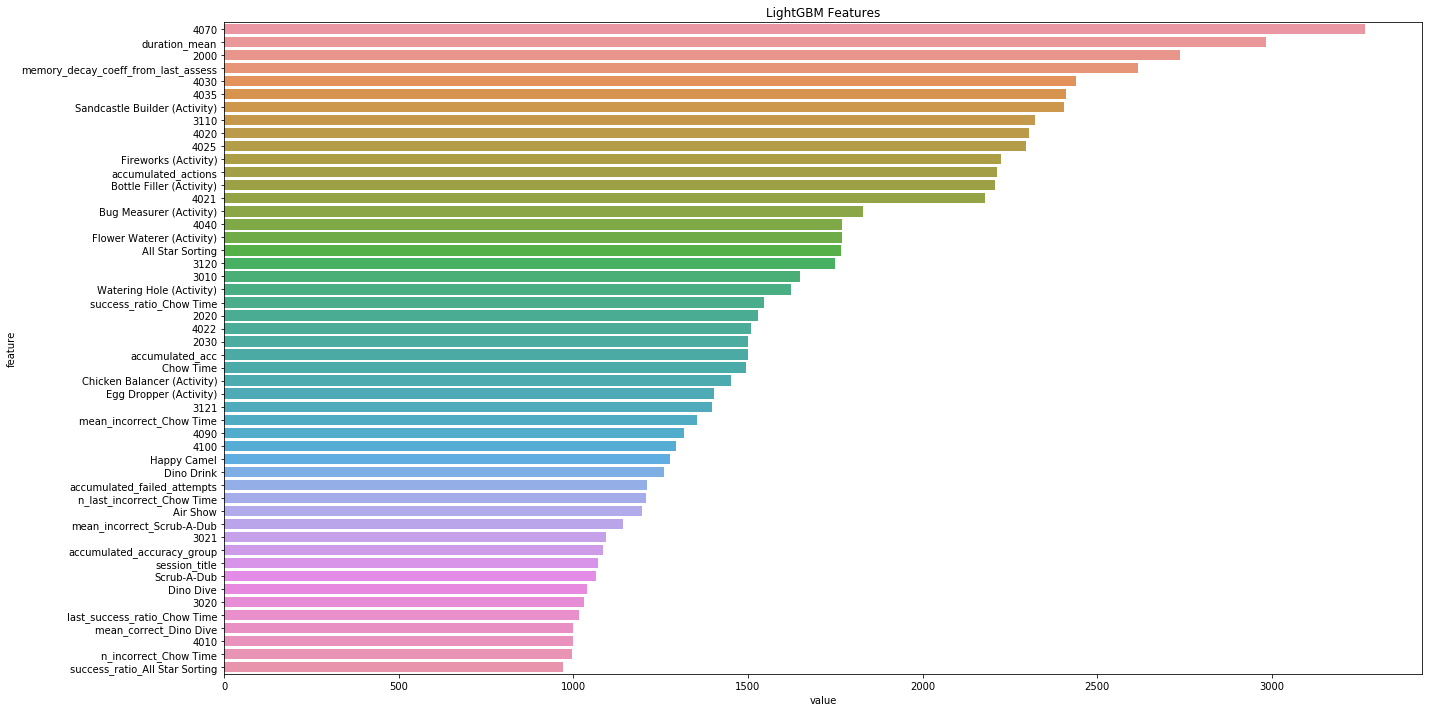

In [24]:
logging.info("Adversarial Validation")
train_adv = x_train.copy()
test_adv = x_valid.copy()

train_adv["target"] = 0
test_adv["target"] = 1
train_test_adv = pd.concat([train_adv, test_adv], axis=0,
                           sort=False).reset_index(drop=True)
split_params: dict = merged_config["av"]["split_params"]
kf = KFold(
    random_state=split_params["random_state"],
    n_splits=split_params["n_splits"],
    shuffle=True)
splits = list(kf.split(train_test_adv))
aucs = []
importance = np.zeros(len(cols))
for trn_idx, val_idx in splits:
    x_train_adv = train_test_adv.loc[trn_idx, cols]
    y_train_adv = train_test_adv.loc[trn_idx, "target"]
    x_val_adv = train_test_adv.loc[val_idx, cols]
    y_val_adv = train_test_adv.loc[val_idx, "target"]

    train_lgb = lgb.Dataset(x_train_adv, label=y_train_adv)
    valid_lgb = lgb.Dataset(x_val_adv, label=y_val_adv)

    model_params = merged_config["av"]["model_params"]
    train_params = merged_config["av"]["train_params"]
    clf = lgb.train(
        model_params,
        train_lgb,
        valid_sets=[train_lgb, valid_lgb],
        valid_names=["train", "valid"],
        **train_params)

    aucs.append(clf.best_score)
    importance += clf.feature_importance(
        importance_type="gain") / len(splits)

# Check the feature importance
feature_imp = pd.DataFrame(
    sorted(zip(importance, cols)), columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("LightGBM Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_adv.png")

merged_config["av_result"] = dict()
merged_config["av_result"]["score"] = dict()
for i, auc in enumerate(aucs):
    merged_config["av_result"]["score"][f"fold{i}"] = auc

merged_config["av_result"]["feature_importances"] = \
    feature_imp.set_index("feature").sort_values(
        by="value",
        ascending=False
    ).head(100).to_dict()["value"]

### Train model

#### CatBoost model 

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 294ms	remaining: 29m 21s
100:	learn: 0.5727848	test: 0.5802992	best: 0.5802992 (100)	total: 22.9s	remaining: 22m 18s
200:	learn: 0.6003355	test: 0.6105907	best: 0.6112162 (199)	total: 46.5s	remaining: 22m 21s
300:	learn: 0.6099590	test: 0.6162002	best: 0.6181591 (277)	total: 1m 10s	remaining: 22m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6181590786
bestIteration = 277

Shrink model to first 278 iterations.
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 233ms	remaining: 23m 18s
100:	learn: 0.5732150	test: 0.5687999	best: 0.5687999 (100)	total: 22.8s	remaining: 22m 10s
200:	learn: 0.6000868	test: 0.5937941	best: 0.5947988 (193)	total: 47.5s	remaining: 22m 51s
300:	learn: 0.6143507	test: 0.6064070	best: 0.6064070 (300)	total: 1m 11s	remaining: 22m 29s
400:	learn: 0.6257497	test: 0.6076452	best: 0.6084756 (379)	total: 1m 36s	remaining: 22m 30s
500:	learn: 0.6332635	test: 0.6095513	b

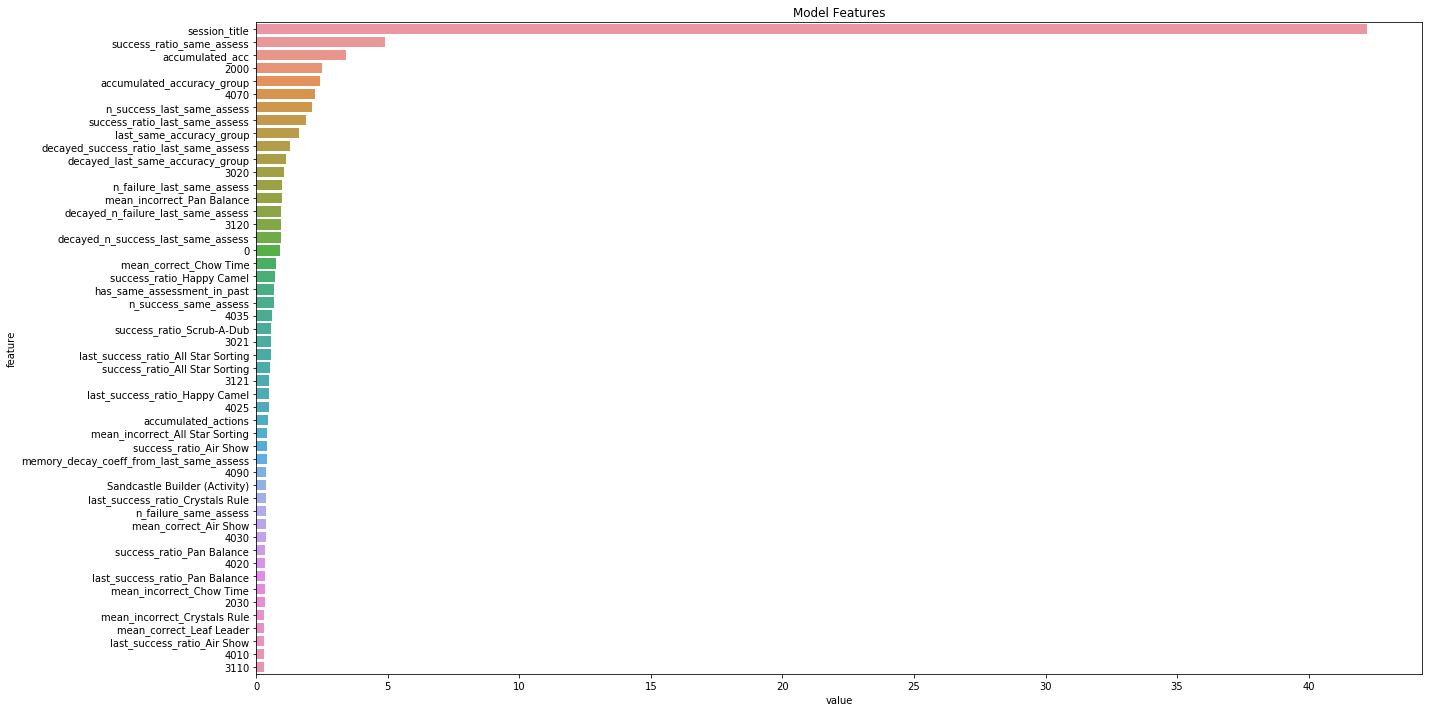

In [32]:
logging.info("Train model")
logging.info("CatBoost model")

# get folds
x_train["group"] = groups
splits = get_validation(x_train, merged_config)
x_train.drop("group", axis=1, inplace=True)

cat_model = get_model(cat_config)
cat_models, cat_oof_preds, cat_test_preds, feature_importance, cat_eval_results = cat_model.cv(
    y_train, x_train, x_test, cols, splits, cat_config, log=True)

merged_config["cat_eval_results"] = dict()
for k, v in cat_eval_results.items():
    merged_config["cat_eval_results"][k] = v

feature_imp = feature_importance.reset_index().rename(columns={
    "index": "feature",
    0: "value"
})
plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_cat_model.png")

#### LGBM model

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.313775	train's qwk: 0.72223	valid's rmse: 0.35694	valid's qwk: 0.542412
[200]	train's rmse: 0.263461	train's qwk: 0.814643	valid's rmse: 0.336575	valid's qwk: 0.608223
[300]	train's rmse: 0.23323	train's qwk: 0.853144	valid's rmse: 0.331126	valid's qwk: 0.616267
[400]	train's rmse: 0.210631	train's qwk: 0.882172	valid's rmse: 0.329918	valid's qwk: 0.618941
Early stopping, best iteration is:
[347]	train's rmse: 0.221751	train's qwk: 0.868971	valid's rmse: 0.330162	valid's qwk: 0.621574
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.312824	train's qwk: 0.724296	valid's rmse: 0.354161	valid's qwk: 0.563387
[200]	train's rmse: 0.261794	train's qwk: 0.816217	valid's rmse: 0.334823	valid's qwk: 0.607313
[300]	train's rmse: 0.231391	train's qwk: 0.85771	valid's rmse: 0.32995	valid's qwk: 0.615931
[400]	train's rmse: 0.20858	train's qwk: 0.885598	valid's rmse: 0.329029	valid

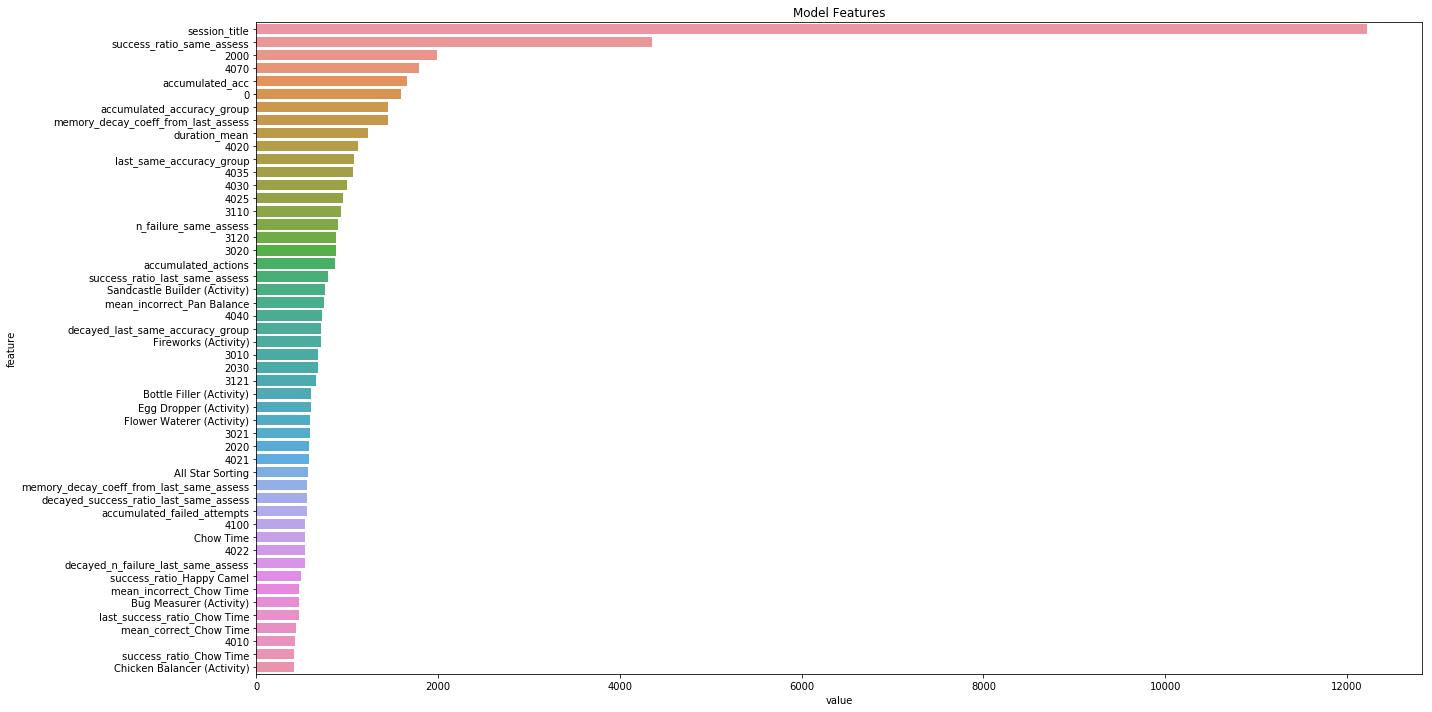

In [33]:
logging.info("LightGBM model")

# get folds
x_train["group"] = groups
splits = get_validation(x_train, merged_config)
x_train.drop("group", axis=1, inplace=True)

lgb_model = get_model(lgb_config)
lgb_models, lgb_oof_preds, lgb_test_preds, feature_importance, lgb_eval_results = lgb_model.cv(
    y_train, x_train, x_test, cols, splits, lgb_config, log=True)

merged_config["lgb_eval_results"] = dict()
for k, v in lgb_eval_results.items():
    merged_config["lgb_eval_results"][k] = v

feature_imp = feature_importance.reset_index().rename(columns={
    "index": "feature",
    0: "value"
})
plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_lgb_model.png")

### Save

In [34]:
save_path = output_dir / "output.json"
save_json(merged_config, save_path)
np.save(output_dir / "cat_oof_preds.npy", cat_oof_preds)
np.save(output_dir / "lgb_oof_preds.npy", lgb_oof_preds)

with open(output_dir / "cat_model.pkl", "wb") as m:
    pickle.dump(cat_models, m)
    
with open(output_dir / "lgb_model.pkl", "wb") as m:
    pickle.dump(lgb_models, m)

### Ensemble

In [35]:
cat_lgb_oof = (cat_model.raw_oof_preds + lgb_model.raw_oof_preds) / 2
OptR = OptimizedRounder(n_classwise=20, n_overall=20)
OptR.fit(cat_lgb_oof, y_train)
cat_lgb_optimized = OptR.predict(cat_lgb_oof)

cat_lgb_oof_score = calc_metric(cat_lgb_optimized, y_train)
print(f"Optimized QWK: {cat_lgb_oof_score:.4f}")
logging.info(f"Optimized QWK: {cat_lgb_oof_score:.4f}")

Optimized QWK: 0.6043


In [36]:
cat_lgb_test = (cat_model.raw_test_preds + lgb_model.raw_test_preds) / 2
cat_lgb_test_optimized = OptR.predict(cat_lgb_test)

### Make submission

In [37]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = cat_lgb_test_optimized
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
